In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-localapprox-integration)=
# Numerical integration

In calculus you learn that the elegant way to evaluate a definite integral is to apply the Fundamental Theorem of Calculus and find an antiderivative. The connection is so profound and pervasive that it's easy to overlook that a definite integral is a numerical quantity existing independently of antidifferentiation.  However, most conceivable integrands have no antiderivative in terms of familiar functions.

(demo-int-antideriv)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

The antiderivative of $e^x$ is, of course, itself. That makes evaluation of $\int_0^1 e^x\,dx$ by the Fundamental Theorem trivial.

In [2]:
exact = exp(1)-1

1.718281828459045

```{index} ! Julia; quadgk
```

The Julia package `QuadGK` has an all-purpose numerical integrator that estimates the value without finding the antiderivative first. As you can see here, it's often just as accurate.

In [3]:
Q,errest = quadgk(x->exp(x),0,1)
@show Q;

Q = 1.718281828459045


The numerical approach is also far more robust. For example, $e^{\,\sin x}$ has no useful antiderivative. But numerically, it's no more difficult.

In [4]:
Q,errest = quadgk(x->exp(sin(x)),0,1)
@show Q;

Q = 1.6318696084180515


When you look at the graphs of these functions, what's remarkable is that one of these areas is basic calculus while the other is almost impenetrable analytically. From a numerical standpoint, they are practically the same problem.

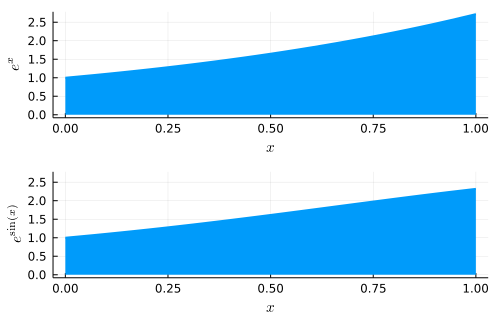

In [5]:
plot([exp,x->exp(sin(x))],0,1,fill=0,layout=(2,1),
    xlabel=L"x",ylabel=[L"e^x" L"e^{\sin(x)}"],ylim=[0,2.7])

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

```{index} ! numerical integration
```

```{index} see: quadrature; numerical integration
```

Numerical integration, which also goes by the older name *quadrature*, is performed by combining values of the integrand sampled at nodes. In this section we will assume equally spaced nodes using the definitions

```{math}
  :label: nc-nodes
  t_i = a +i h, \quad h=\frac{b-a}{n}, \qquad i=0,\ldots,n.
```

::::{proof:definition} Numerical integration formula
A **numerical integration** formula is a list of **weights** $w_0,\ldots,w_n$ chosen so that for all $f$ in some class of functions,

```{math}
  :label: quadrature
  \begin{split}
    \int_a^b f(x)\, dx \approx h \sum_{i=0}^n w_if(t_i) =  h \bigl[ w_0f(t_0)+w_1f(t_1)+\cdots w_nf(t_n) \bigr],
  \end{split}
```

with the $t_i$ defined in {eq}`nc-nodes`. The weights are independent of $f$ and $h$.
::::

Numerical integration formulas can be applied to sequences of data values even if no function is explicitly known to generate them. For our presentation and implementations, however, we assume that $f$ is known and can be evaluated anywhere.

```{index} interpolation; by piecewise polynomials
```

A straightforward way to derive integration formulas is to mimic the approach taken for finite differences: find an interpolant and operate exactly on it. 

## Trapezoid formula

One of the most important integration formulas results from integration of the piecewise linear interpolant (see {numref}`section-localapprox-pwlin`). Using the cardinal basis form of the interpolant in {eq}`plbasis`, we have

```{math}
\int_a^b f(x) \, dx \approx \int_a^b \sum_{i=0}^n f(t_i) H_i(x)\, dx = \sum_{i=0}^n f(t_i) \left[ \int_a^b H_i(x)\right]\, dx.
```

Thus we can identify the weights as $w_i = h^{-1} \int_a^b H_i(x)\, dx$. Using areas of triangles, it's trivial to derive that

```{math}
:label: hatintegral
w_i = \begin{cases}
1, & i=1,\ldots,n-1,\\
\frac{1}{2}, & i=0,n.
\end{cases}
```

Putting everything together, the resulting formula is

```{math}
:label: trapezoid
\begin{split}
  \int_a^b f(x)\, dx \approx T_f(n) &= h\left[
    \frac{1}{2}f(t_0) + f(t_1) + f(t_2) + \cdots + f(t_{n-1}) +
    \frac{1}{2}f(t_n) \right].
\end{split}
```

```{index} ! trapezoid formula; for integration
```

::::{proof:definition} Trapezoid formula
The **trapezoid formula** is a numerical integration formula in the form {eq}`quadrature`, with

$$
w_i = \begin{cases}
  \frac{1}{2},& i=0 \text{ or } i=n, \\ 
  1, & 0 < i < n.
  \end{cases}
$$
::::

Geometrically, as illustrated in {numref}`fig-trapezoid`, the trapezoid formula sums of the areas of trapezoids approximating the region under the curve $y=f(x)$.[^comp]

[^comp]: Some texts distinguish between a formula for a single subinterval $[t_{k-1},t_k]$ and a *composite* formula that adds them up over the whole interval to get {eq}`trapezoid`.

The trapezoid formula is the Swiss Army knife of integration formulas. A short implementation is given as {numref}`Function {number} <function-trapezoid>`.


```{figure} figures/trapezoid.svg
:name: fig-trapezoid
Trapezoid formula for integration. The piecewise linear interpolant defines trapezoids that approximate the region under the curve.
```

(function-trapezoid)=
````{proof:function} trapezoid
**Trapezoid formula for numerical integration**

```{code-block} julia1
:lineno-start: 1
"""
    trapezoid(f,a,b,n)

Apply the trapezoid integration formula for integrand `f` over
interval [`a`,`b`], broken up into `n` equal pieces. Returns
the estimate, a vector of nodes, and a vector of integrand values at the
nodes.
"""
function trapezoid(f,a,b,n)
    h = (b-a)/n
    t = range(a,b,length=n+1)
    y = f.(t)
    T = h * ( sum(y[2:n]) + 0.5*(y[1] + y[n+1]) )
    return T,t,y
end
```
````

Like finite-difference formulas, numerical integration formulas have a truncation error.

```{index} ! truncation error; of a numerical integration formula, ! order of accuracy; of numerical integration
```

::::{proof:definition} Truncation error of a numerical integration formula
For the numerical integration formula {eq}`quadrature`, the **truncation error** is

```{math}
:label: truncint
\tau_f(h) = \int_a^b f(x) \, dx - h \sum_{i=0}^{n} w_i f(t_i).
```

The **order of accuracy** is as defined in {numref}`Definition {number} <definition-fd-converge-ooa>`.
::::

In {numref}`Theorem %s <theorem-pwlin-converge>` we stated that the pointwise error in a piecewise linear interpolant with equal node spacing $h$ is bounded by $O(h^2)$ as $h\rightarrow 0$. Using $I$ to stand for the exact integral of $f$ and $p$ to stand for the piecewise linear interpolant, we obtain

```{math}
\begin{split}
  I - T_f(n) = I - \int_a^b p(x)\, dx &= \int_a^b \bigl[f(x)-p(x)\bigr] \, dx \\
  &\le (b-a) \max_{x\in[a,b]} |f(x)-p(x)| = O(h^2).
\end{split}
```

```{index} ! Euler–Maclaurin formula
```

A more thorough statement of the truncation error is known as the **Euler–Maclaurin formula**,

```{math}
:label: eulermaclaurin
\int_a^b f(x)\, dx &= T_f(n) - \frac{h^2}{12} \left[ f'(b)-f'(a) \right] + \frac{h^4}{740} \left[ f'''(b)-f'''(a) \right] + O(h^6) \\
    &= T_f(n) - \sum_{k=1}^\infty \frac{B_{2k}h^{2k}}{(2k)!}  \left[ f^{(2k-1)}(b)-f^{(2k-1)}(a) \right],
```

where the $B_{2k}$ are constants known as *Bernoulli numbers*. Unless we happen to be fortunate enough to have a function with $f'(b)=f'(a)$, we should expect truncation error at second order and no better.

::::{proof:observation}
The trapezoid integration formula is second-order accurate.
::::

(demo-int-trap)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We will approximate the integral of the function $f(x)=e^{\sin 7x}$ over the interval $[0,2]$.

In [6]:
f = x -> exp(sin(7*x));
a = 0;  b = 2;

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
In lieu of the exact value, we use the `QuadGK` package to find an accurate result.

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
If a function has multiple return values, you can use an underscore `_` to indicate a  return value you want to ignore.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [7]:
Q,_ = quadgk(f,a,b,atol=1e-14,rtol=1e-14);
println("Integral = $Q")

Integral = 2.6632197827615394


Here is the trapezoid result at $n=40$, and its error.

In [8]:
T,t,y = FNC.trapezoid(f,a,b,40)
@show (T,Q-T);

(T, Q - T) = (2.662302935602287, 0.0009168471592522209)


In order to check the order of accuracy, we increase $n$ by orders of magnitude and observe how the error decreases.

In [9]:
n = [ 10^n for n in 1:5 ]
err = []
for n in n
    T,t,y = FNC.trapezoid(f,a,b,n)
    push!(err,Q-T)
end

pretty_table([n err],["n","error"])

┌────────┬─────────────┐
│      n │       error │
├────────┼─────────────┤
│     10 │   0.0120254 │
│    100 │ 0.000147305 │
│   1000 │  1.47415e-6 │
│  10000 │  1.47416e-8 │
│ 100000 │ 1.47417e-10 │
└────────┴─────────────┘


Each increase by a factor of 10 in $n$ cuts the error by a factor of about 100, which is consistent with second-order convergence. Another check is that a log-log graph should give a line of slope $-2$ as $n\to\infty$.

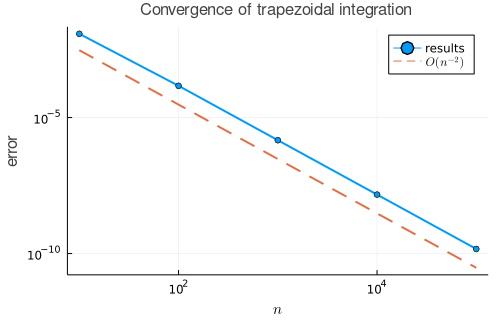

In [10]:
plot(n,abs.(err),m=:o,label="results",
    xaxis=(:log10,L"n"),yaxis=(:log10,"error"),
    title="Convergence of trapezoidal integration")

# Add line for perfect 2nd order.
plot!(n,3e-3*(n/n[1]).^(-2),l=:dash,label=L"O(n^{-2})")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```



## Extrapolation

If evaluations of $f$ are computationally expensive, we want to get as much accuracy as possible from them by using a higher-order formula. There are many routes for doing so; for example, we could integrate a not-a-knot cubic spline interpolant. However, splines are difficult to compute by hand, and as a result different methods were developed before computers came on the scene.

```{index} ! extrapolation
```

Knowing the structure of the error allows the use of **extrapolation** to improve accuracy. Suppose a quantity $A_0$ is approximated by an algorithm $A(h)$ with an
error expansion

```{math}
  :label: extraperror
  A_0 = A(h) + c_1 h + c_2 h^2 + c_3 h^3 + \cdots.
```

Crucially, it is not necessary to know the values of the error constants $c_k$, merely that they exist and are independent of $h$. 

Using $I$ for the exact integral of $f$, the trapezoid formula has

```{math}
  I = T_f(n) + c_2 h^2 + c_4 h^{4} + \cdots,
```

as proved by the Euler–Maclaurin formula {eq}`eulermaclaurin`. The error constants depend on $f$ and can't be evaluated in general, but we know that this expansion holds. For convenience we recast the error expansion in terms of $n=O(h^{-1})$:

```{math}
  :label: traperrorexpansion
  I = T_f(n) + c_2 n^{-2} + c_4 n^{-4} + \cdots.
```

We now make the simple observation that

```{math}
  :label: traperrorexpansion2n
  I = T_f(2n) + \tfrac{1}{4} c_2 n^{-2} + \tfrac{1}{16} c_4 n^{-4} + \cdots.
```

It follows that if we combine {eq}`traperrorexpansion` and {eq}`traperrorexpansion2n` correctly, we can cancel out the second-order term in the error. Specifically, define

```{math}
  :label: nc-simpson
  S_f(2n) = \frac{1}{3} \Bigl[ 4 T_f(2n) - T_f(n) \Bigr].
```

(We associate $2n$ rather than $n$ with the extrapolated result because of the total number of nodes needed.) Then

```{math}
  :label: extraplevel1
  I = S_f(2n) + O(n^{-4}) =  b_4 n^{-4} + b_6 n^{-6} + \cdots.
```

```{index} ! Simpson's formula
```

The formula {eq}`nc-simpson` is called **Simpson's formula**, or *Simpson's rule*. A different presentation and derivation are considered in [Exercise 4](problem-simpson).

Equation {eq}`extraplevel1` is another particular error expansion in the form {eq}`extraperror`, so we can extrapolate again! The details change only a little. Considering that

```{math}
  I = S_f(4n) = \tfrac{1}{16} b_4 n^{-4} + \tfrac{1}{64} b_6 n^{-6} + \cdots,
```

the proper combination this time is

```{math}
  :label: nc-sixth
  R_f(4n) = \frac{1}{15} \Bigl[ 16 S_f(4n) - S_f(2n) \Bigr],
```

which is sixth-order accurate. Clearly the process can be repeated to get eighth-order accuracy and beyond. Doing so goes by the name of **Romberg integration**, which we will not present in full generality.

## Node doubling

Note in {eq}`nc-sixth` that $R_f(4n)$ depends on $S_f(2n)$ and $S_f(4n)$, which in turn depend on $T_f(n)$, $T_f(2n)$, and $T_f(4n)$.  There is a useful benefit realized by doubling of the nodes in each application of the trapezoid formula. As shown in {numref}`figure-node-doubling`, when doubling $n$, only about half of the nodes are new ones, and previously computed function values at the other nodes can be reused.


```{figure} figures/node-doubling.svg
:name: figure-node-doubling
Dividing the node spacing by half introduces new nodes only at midpoints, allowing the function values at existing nodes to be reused for extrapolation.
```

Specifically, we have 

```{math}
:label: nc-doubling
\begin{split}
  T_f(2m) & = \frac{1}{2m} \left[  \frac{1}{2} f(a) + \frac{1}{2} f(b) + \sum_{i=1}^{2m-1}  f\Bigl( a + \frac{i}{2m} \Bigr) \right]\\[1mm]
  & = \frac{1}{2m} \left[  \frac{1}{2} f(a) + \frac{1}{2} f(b)\right] + \frac{1}{2m} \sum_{k=1}^{m-1}  f\Bigl( a+\frac{2k}{2m} \Bigr)  + \frac{1}{2m} \sum_{k=1}^{m} f\Bigl( a+\frac{2k-1}{2m} \Bigr) \\[1mm]
  &=  \frac{1}{2m} \left[  \frac{1}{2} f(a) + \frac{1}{2} f(b) + \sum_{k=1}^{m-1} f\Bigl( a+\frac{k}{m} \Bigr) \right] + \frac{1}{2m} \sum_{k=1}^{m}  f\Bigl( a+\frac{2k-1}{2m} \Bigr)  \\[1mm]
  &= \frac{1}{2} T_f(m) + \frac{1}{2m} \sum_{k=1}^{m-1}  f\left(t_{2k-1} \right),
\end{split}
```

where the nodes referenced in the last line are relative to $n=2m$. Hence in passing from $n=m$ to $n=2m$, new integrand evaluations are needed only at the odd-numbered nodes of the finer grid. 

(demo-int-extrap)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We estimate $\displaystyle\int_0^2 x^2 e^{-2x}\, dx$ using extrapolation. First we use `quadgk` to get an accurate value.

In [11]:
f = x -> x^2*exp(-2*x);
a = 0;  b = 2; 
Q,_ = quadgk(f,a,b,atol=1e-14,rtol=1e-14)
@show Q;

Q = 0.1904741736116139


We start with the trapezoid formula on $n=N$ nodes.

In [12]:
N = 20;       # the coarsest formula
n = N;  h = (b-a)/n;
t = h*(0:n);   y = f.(t);

We can now apply weights to get the estimate $T_f(N)$.

In [13]:
T = [ h*(sum(y[2:n]) + y[1]/2 + y[n+1]/2) ]

1-element Vector{Float64}:
 0.19041144993926787

Now we double to $n=2N$, but we only need to evaluate $f$ at every other interior node and apply {eq}`nc-doubling`.

In [14]:
n = 2n;  h = h/2;  t = h*(0:n);
T = [ T; T[end]/2 + h*sum( f.(t[2:2:n]) ) ]

2-element Vector{Float64}:
 0.19041144993926787
 0.19045880585951175

We can repeat the same code to double $n$ again.

In [15]:
n = 2n;  h = h/2;  t = h*(0:n);
T = [ T; T[end]/2 + h*sum( f.(t[2:2:n]) ) ]

3-element Vector{Float64}:
 0.19041144993926787
 0.19045880585951175
 0.1904703513046443

Let us now do the first level of extrapolation to get results from Simpson's formula. We combine the elements `T[i]` and `T[i+1]` the same way for $i=1$ and $i=2$.

In [16]:
S = [ (4T[i+1]-T[i])/3 for i in 1:2 ]

2-element Vector{Float64}:
 0.19047459116625973
 0.19047419978635513

With the two Simpson values $S_f(N)$ and $S_f(2N)$ in hand, we can do one more level of extrapolation to get a sixth-order accurate result.

In [17]:
R = (16S[2] - S[1]) / 15

0.1904741736943615

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
We can make a triangular table of the errors:

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The value `nothing` equals nothing except `nothing`.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [18]:
err = [ T.-Q [nothing;S.-Q] [nothing;nothing;R-Q] ]
pretty_table(err,["order 2","order 4","order 6"])

┌─────────────┬────────────┬─────────────┐
│     order 2 │    order 4 │     order 6 │
├─────────────┼────────────┼─────────────┤
│ -6.27237e-5 │    nothing │     nothing │
│ -1.53678e-5 │ 4.17555e-7 │     nothing │
│ -3.82231e-6 │ 2.61747e-8 │ 8.27476e-11 │
└─────────────┴────────────┴─────────────┘


If we consider the computational time to be dominated by evaluations of $f$, then we have obtained a result with about twice as many accurate digits as the best trapezoid result, at virtually no extra cost.

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Exercises

(problem-integration-tests)=
% must be kept as #1

1. ⌨ For each integral below, use {numref}`Function {number} <function-trapezoid>` to estimate the integral for $n=10\cdot 2^k$ nodes for $k=1,2,\ldots,10$. Make a log-log plot of the errors and confirm or refute second-order accuracy. (These integrals were taken from {cite}`baileyComparisonThree2005`.)

    **(a)** $\displaystyle \int_0^1 x\log(1+x)\, dx = \frac{1}{4}$

    **(b)** $\displaystyle \int_0^1 x^2 \tan^{-1}x\, dx = \frac{\pi-2+2\log 2}{12}$

    **(c)** $\displaystyle \int_0^{\pi/2}e^x \cos x\, dx = \frac{e^{\pi/2}-1}{2}$

    **(d)** $\displaystyle \int_0^1 \sqrt{x} \log(x) \, dx = -\frac{4}{9}$ (Note: Although the integrand has the limiting value zero as $x\to 0$, it cannot be evaluated naively at $x=0$. You can start the integral at $x=\macheps$ instead.)

    **(e)** $\displaystyle \int_0^1 \sqrt{1-x^2}\,\, dx = \frac{\pi}{4}$
  
2. ✍ The Euler–Maclaurin error expansion {eq}`eulermaclaurin` for the trapezoid formula implies that if we could cancel out the term due to $f'(b)-f'(a)$, we would obtain fourth-order accuracy. We should not assume that $f'$ is available, but approximating it with finite differences can achieve the same goal. Suppose the forward difference formula {eq}`forwardFD21` is used for $f'(a)$, and its reflected backward difference is used for $f'(b)$. Show that the resulting modified trapezoid formula is
 
    ```{index} ! Gregory integration formula
    ```

    ```{math}
      :label: gregory
        G_f(h) = T_f(h) - \frac{h}{24} \left[ 3\Bigl( f(t_n)+f(t_0) \Bigr) -4\Bigr( f(t_{n-1}) + f(t_1) \Bigr) + \Bigl( f(t_{n-2})+f(t_2)   \Bigr) \right],
    ```

    which is known as a **Gregory integration formula**.


3. ⌨ Repeat each integral in Exercise 1 above using Gregory integration {eq}`gregory` instead of the trapezoid formula. Compare the observed errors to fourth-order convergence.

    (problem-simpson)=
4. ✍  Simpson's formula can be derived without appealing to extrapolation.

    **(a)** Show that

    ```{math}
    p(x) = \beta + \frac{\gamma-\alpha}{2h}\, x + \frac{\alpha-2\beta+\gamma}{2h^2}\, x^2
    ```

    interpolates the three points $(-h,\alpha)$, $(0,\beta)$, and $(h,\gamma)$.

    **(b)** Find

    ```{math}
      \int_{-h}^h p(s)\, ds,
    ```

    where $p$ is the quadratic polynomial from part (a), in terms of $h$, $\alpha$, $\beta$, and $\gamma$.
  
    **(c)** Assume equally spaced nodes in the form $t_i=a+ih$, for $h=(b-a)/n$ and $i=0,\ldots,n$. Suppose $f$ is approximated by $p(x)$ over the subinterval $[t_{i-1},t_{i+1}]$. Apply the result from part (b) to find

    ```{math}
      \int_{t_{i-1}}^{t_{i+1}} f(x)\, dx \approx \frac{h}{3} \bigl[ f(t_{i-1}) + 4f(t_i) + f(t_{i+1}) \bigr].
    ```

    (Use the change of variable $s=x-t_i$.)

    **(d)** Now also assume that $n=2m$ for an integer $m$. Derive Simpson's formula,

    ```{math}
      :label: simpson
      \begin{split}
        \int_a^b f(x)\, dx \approx  \frac{h}{3}\bigl[ &f(t_0) + 4f(t_1) + 2f(t_2) + 4f(t_3) + 2f(t_4) + \cdots\\
        &+ 2f(t_{n-2}) + 4f(t_{n-1}) + f(t_n) \bigr].
      \end{split}
     ```

5. ✍ Show that the Simpson formula {eq}`simpson` is equivalent to $S_f(n/2)$, given the definition of $S_f$ in {eq}`nc-simpson`.

6. ⌨ For each integral in Exercise 1 above, apply the Simpson formula {eq}`simpson` and compare the errors to fourth-order convergence.

7. ⌨ For $n=10,20,30,\ldots,200$, compute the trapezoidal approximation to

    ```{math}
    \int_{0}^1 \frac{1}{2.01+\sin (6\pi x)-\cos(2\pi x)} \,d x \approx 0.9300357672424684.
    ```

    Make two separate plots of the absolute error as a function of $n$, one using a log-log scale and the other using log-linear. The graphs suggest that the error asymptotically behaves as $C \alpha^n$ for some $C>0$ and some $0<\alpha<1$. How does this result relate to {eq}`eulermaclaurin`?


8. ⌨ For each integral in Exercise 1 above, extrapolate the trapezoidal results two levels to get sixth-order accurate results, and compute the errors for each value.

9. ✍ Find a formula like {eq}`nc-sixth` that extrapolates two values of $R_f$ to obtain an eighth-order accurate one.